## Preprocessing POC  
Using [IBM](https://developer.ibm.com/technologies/data-science/articles/an-automatic-method-to-identify-tissues-from-big-whole-slide-images-pt1/) as a base to see where this goes.

In [1]:
import openslide
import random
import datetime

import numpy as np
import h5py

from skimage.filters import threshold_otsu
from matplotlib import pyplot as plt

### DOWNLOAD THESE FROM GIT OR CLOSE THE WHOLE REPOSITORY
### https://gitlab.com/deep.TEACHING/educational-materials/tree/master/notebooks/medical-image-classification
from preprocessing.datamodel import SlideManager
from preprocessing.processing import split_negative_slide, split_positive_slide, create_tumor_mask, rgb2gray
from preprocessing.util import TileMap
import os

%matplotlib inline

In [2]:
CAM_BASE_DIR = '/home/sarah/ForthBrainCancer-Dataset/'

In [3]:
CAM16_DIR = CAM_BASE_DIR + 'CAMELYON16/'
CAM17_DIR = CAM_BASE_DIR + 'CAMELYON17/'

In [4]:
for i in range(134,160):
    image_path = '/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/training/normal'
    num = 'normal_' + str(i) + '.tif'
    img = os.path.join(image_path, num)
    print(img)
    image = openslide.OpenSlide(img)

/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/training/normal/normal_134.tif
/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/training/normal/normal_135.tif
/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/training/normal/normal_136.tif
/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/training/normal/normal_137.tif
/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/training/normal/normal_138.tif
/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/training/normal/normal_139.tif
/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/training/normal/normal_140.tif
/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/training/normal/normal_141.tif
/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/training/normal/normal_142.tif
/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/training/normal/normal_143.tif
/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/training/normal/normal_144.tif
/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/training/normal/normal_145.tif
/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/trai

In [5]:
# for minimal data set:
mgr = SlideManager(cam16_dir=CAM16_DIR)
#mgr = SlideManager(cam17_dir=CAM17_DIR)

# for whole train set (CAMELYON16 and 17):
# mgr = SlideManager(cam16_dir='some/path/CAMELYON16', cam17_dir='some/path/CAMELYON17')

print(mgr)

dict_items([('normal_063.tif', '/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/training/normal/normal_063.tif'), ('normal_147.tif', '/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/training/normal/normal_147.tif'), ('normal_018.tif', '/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/training/normal/normal_018.tif'), ('normal_140.tif', '/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/training/normal/normal_140.tif'), ('normal_064.tif', '/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/training/normal/normal_064.tif'), ('normal_016.tif', '/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/training/normal/normal_016.tif'), ('normal_132.tif', '/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/training/normal/normal_132.tif'), ('normal_135.tif', '/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/training/normal/normal_135.tif'), ('normal_011.tif', '/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/training/normal/normal_011.tif'), ('normal_149.tif', '/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/tr

In [6]:


# annotated slides (slides with tumor annotation)
slides_anno = mgr.annotated_slides
print('Number of annotated slides: ', len(slides_anno))

# negative slides
slides_negative = mgr.negative_slides
print('Number of positive slides: ', len(slides_negative))

# get a random slide
slide = random.choice(mgr.slides)
print('\nA random slide:')
print(slide)

# list two slide names
print('\nTwo random slide names:')
for name in random.choices(mgr.slide_names, k=2):
    print(' ', name)

# choose a specific slide by name
print('\nSlide by name:')
#print(mgr.get_slide('Normal_160'))
print(mgr.get_slide('tumor_110'))

Number of annotated slides:  111
Number of positive slides:  150

A random slide:
Slide('tumor_020', '/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/training/tumor/tumor_020.tif', None, '/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/training/lesion_annotations/tumor_020.xml')

Two random slide names:
  normal_052
  tumor_035

Slide by name:
Slide('tumor_110', '/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/training/tumor/tumor_110.tif', None, '/home/sarah/ForthBrainCancer-Dataset/CAMELYON16/training/lesion_annotations/tumor_110.xml')


Name: normal_009
Size on layer 0: 97,792 × 220,672 pixel
Layers: 10
State: None
Annotations: 0


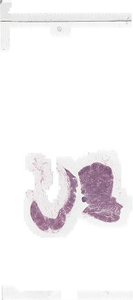

In [7]:
slide = random.choice(mgr.negative_slides)
print('Name: {}\n'
      'Size on layer 0: {:,} × {:,} pixel\n'
      'Layers: {}\n'
      'State: {}\n'
      'Annotations: {}'.format(slide.name,
                               *slide.level_dimensions[0], # openslide method
                               slide.level_count,          # openslide method
                               slide.stage,
                               len(slide.annotations)))

slide.get_thumbnail((300, 300))  # openslide method

Name: tumor_068
Size on layer 0: 97,792 × 217,088 pixel
Layers: 10
State: None
Annotations: 39


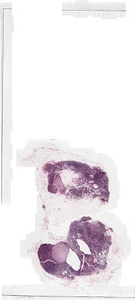

In [8]:
slide = random.choice(mgr.annotated_slides)
print('Name: {}\n'
      'Size on layer 0: {:,} × {:,} pixel\n'
      'Layers: {}\n'
      'State: {}\n'
      'Annotations: {}'.format(slide.name,
                               *slide.level_dimensions[0],  # open slide method
                               slide.level_count,           # open slide method
                               slide.stage,
                               len(slide.annotations)))

slide.get_thumbnail((300, 300))  # open slide method

The Slide method get_full_slide() allows a direct access to the slide as image on a specific level.

Slide dimensions on layer 4:  (6112, 13568)
Image size: (6112, 13568)


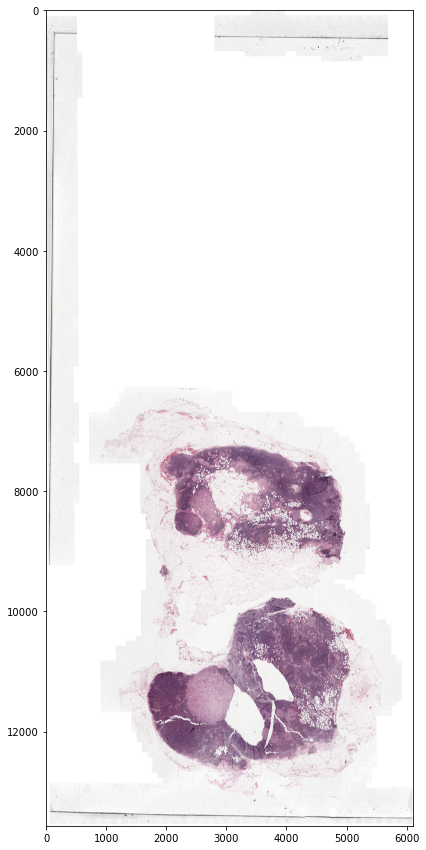

In [9]:
# we cannot show it on level 0, would require ~50+ GByte RAM
level = 4
print('Slide dimensions on layer %i: '%level, slide.level_dimensions[level])
img = slide.get_full_slide(level=level)
print('Image size:', img.size)
plt.figure(figsize=(15,15))
plt.imshow(img)


#### Annotations

Tumor annotations are represented by the Annotation class. Every Annotation object has a name and a polygon encompassing the tumor region. Annotated slides may have multiple Annotation objects.

The Annotation object can create an image of a tumor region with the polygon drawn over. Here the first 3 annotations of the first annotated slide:


Slide name: tumor_003

Annotation name: "_0"
Position on layer 0: Point(x=77529, y=151562)
Size on layer 0: 3,537 × 2,338 pixel

Annotation name: "_1"
Position on layer 0: Point(x=80073, y=153037)
Size on layer 0: 256 × 233 pixel

Annotation name: "_2"
Position on layer 0: Point(x=73736, y=148273)
Size on layer 0: 1,760 × 1,834 pixel

Annotation name: "_3"
Position on layer 0: Point(x=74061, y=146911)
Size on layer 0: 481 × 610 pixel

Annotation name: "_4"
Position on layer 0: Point(x=74861, y=146759)
Size on layer 0: 204 × 350 pixel

Annotation name: "_5"
Position on layer 0: Point(x=74484, y=147850)
Size on layer 0: 179 × 303 pixel

Annotation name: "_6"
Position on layer 0: Point(x=75438, y=148325)
Size on layer 0: 112 × 178 pixel

Annotation name: "_7"
Position on layer 0: Point(x=75223, y=148205)
Size on layer 0: 84 × 150 pixel

Annotation name: "_8"
Position on layer 0: Point(x=75856, y=149684)
Size on layer 0: 185 × 141 pixel

Annotation name: "_9"
Position on layer 0: Point(x=7

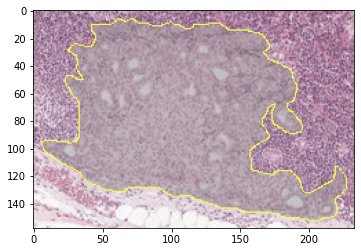

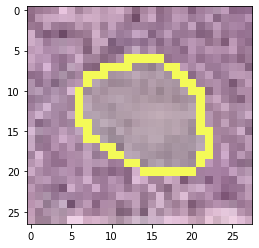

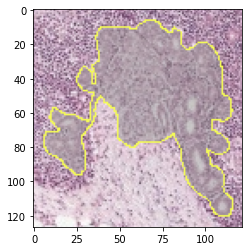

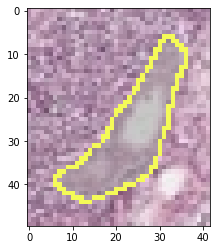

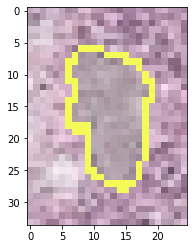

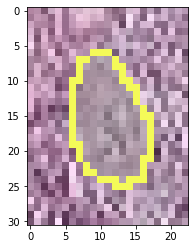

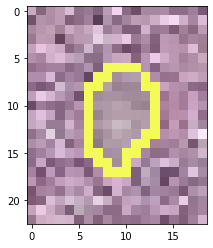

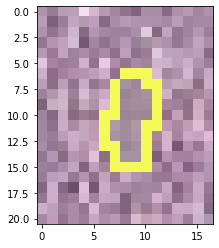

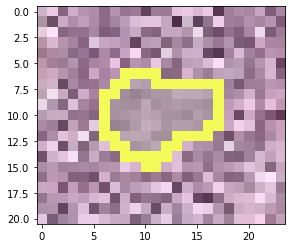

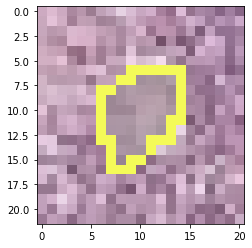

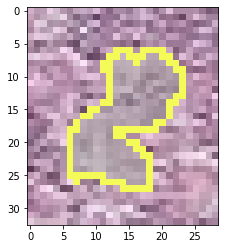

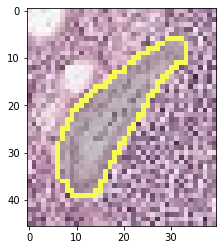

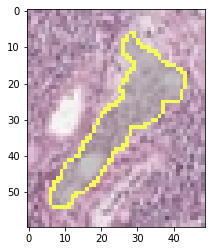

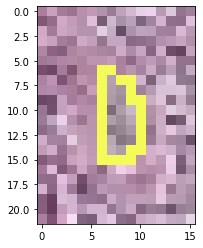

In [10]:
slide = mgr.annotated_slides[2]
print('Slide name: {}\n'.format(slide.name))
for annotation in slide.annotations[:]:
    bounds = annotation.get_boundaries(0)
    print('Annotation name: "{}"\n'
          'Position on layer 0: {}\n'
          'Size on layer 0: {:,} × {:,} pixel\n'.format(annotation.name,
                                                        bounds[0],
                                                        *bounds[1]))
    plt.figure()
    plt.imshow(annotation.get_image())
plt.show()


### Tiling

In general the file size and dimensions of a WSI are much bigger than a convolutional neural network can handle. To be able to predict the cancer status of tissue samples we need to cut each slide into small images, called tiles, which we can feed into a network as training data.

Note: Some preprocessing tasks take a lot of time. In order to reduce calculation time and play arround a bit more with the data we set the magnification level=6 only. In the next notebooks we will work with much higher magnification though.
#### Negative slides

Negative tissue slides are slides of healthy tissue without any tumorous cells. From these negative slides we want to extract as many tiles with tissue as possible and ignore those with only background.

To split the background from the actual tissue data we can use an image processing algorithm based on the Otsu Method which is provided in the scikit-image package. This method calculates a threshold that divides a gray scale image into foreground and background.

As an example we can get a negative slide from the SlideManager:


Slide name: "normal_001"
Tumorous: False


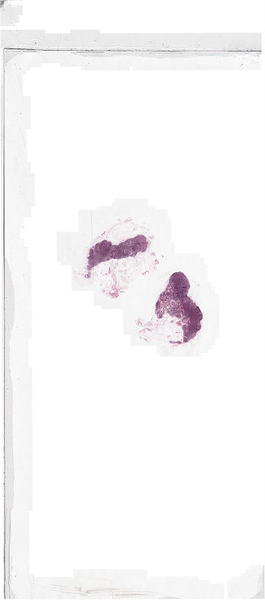

In [11]:


negative_slide = mgr.negative_slides[0]
print('Slide name: "{}"\n'
      'Tumorous: {}'.format(negative_slide.name,
                            negative_slide.has_tumor))
negative_slide.get_thumbnail((600, 600))





Now we can load the image into an NumPy array, convert it to gray scale and calculate the otsu threshold, though we will use another zoom level here.


In [12]:
# load the slide into numpy array
arr = np.asarray(negative_slide.get_full_slide(level=3))
print('array shape:', arr.shape)

# convert it to gray scale
arr_gray = rgb2gray(arr)
print('gray array shape:', arr_gray.shape)

# calculate otsu threshold
threshold = threshold_otsu(arr_gray)
print('otsu threshold:',threshold)

array shape: (27648, 12224, 4)
gray array shape: (27648, 12224)
otsu threshold: 12.646484374999996


The threshold splits the image into background and foreground. Pixels with a value lower are considered background and pixels with a higher value are considered foreground. To visualize this we can create a binary mask:

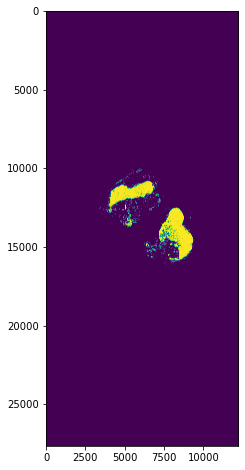

In [13]:
# create an otsu mask
mask = arr_gray > threshold
plt.figure(figsize=(8,8))
plt.imshow(mask)

If we compare the mask with the slide thumbnail above we can see the algorithm successfully separated the pixels with tissue data from the background. The binary mask also allows us to count how many pixels of actual tissue data we have by summing it up:

In [14]:
np.sum(mask)

6648850

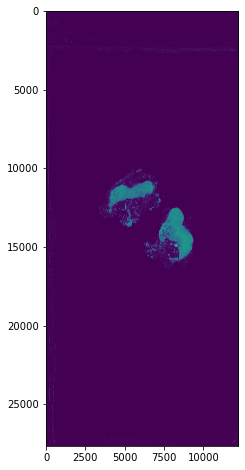

In [15]:
# gray

plt.figure(figsize=(8,8))
plt.imshow(arr_gray)

In [16]:
arr_gray.max()

58.333333333333314

In [17]:
arr_gray

array([[0.66666667, 0.66666667, 0.66666667, ..., 0.        , 0.        ,
        0.        ],
       [0.66666667, 0.66666667, 0.66666667, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [18]:
from skimage import exposure
# img_adapteq = exposure.equalize_adapthist(mask, clip_limit=0.03)



This method to separate background from foreground by creating one binary mask works very well for smaller images and so far we have only been working on layer 6 of the WSI pyramid. But for lower layers with much higher dimension this step can be very memory intensive. To avoid this problem we can calculate the otsu threshold once and then create a mask based on that threshold for every tile of the slide individually.

The function split_negative_slide of the preprocessing module splits a slide into tiles with the specified dimensions. For each tile a binary mask is created based on the otsu threshold. If the sum of this mask is higher than the provided threshold, the tile and its boundaries are returned.


((45056, 88064), (2048, 2048))
((47104, 88064), (2048, 2048))
((49152, 88064), (2048, 2048))


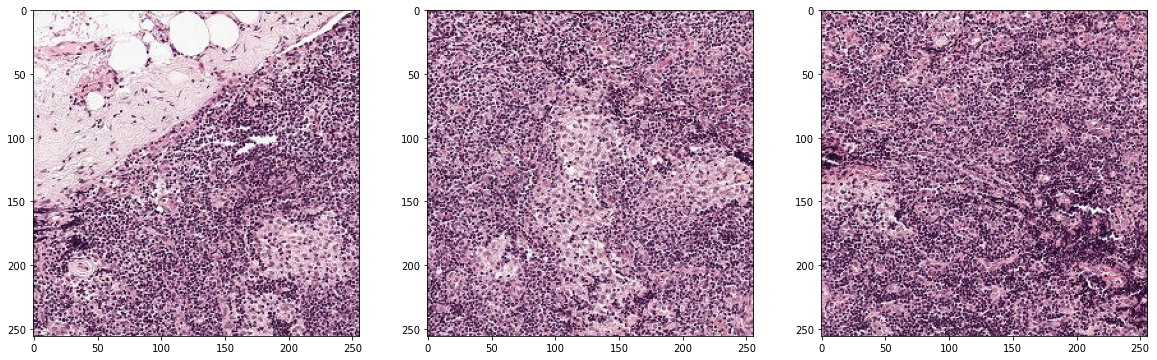

In [19]:
tile_iter = split_negative_slide(
    negative_slide, level=3,
    otsu_threshold=threshold,  # otsu threshold calculated earlier
    tile_size=256,
    overlap=0,                 # no overlap
    poi_threshold=0.9)         # only select tiles with at least 90% tissue

# plot the first 3 tiles
plt.figure(figsize=(20, 6))
for i, (tile, bounds) in enumerate(tile_iter):
    print(bounds)          # tile boundaries on layer 0
    plt.subplot(1, 3, i+1)
    plt.imshow(tile)       # plot the tile

    if i >= 2:
        break

The TileMap class can be used to display the tiles and see which areas of the slide are selected. It's image attribute is an image of the WSI with all tiles marked:

start splitting 2021-01-11 01:39:55.261061
end splitting 2021-01-11 01:39:55.261333


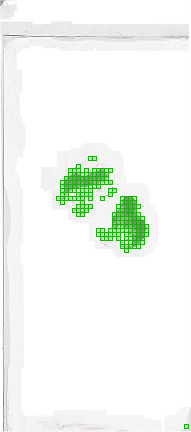

In [20]:
#actual# initialize the map with the slide itself
tm = TileMap(negative_slide)

print('start splitting', datetime.datetime.now())
# create a new and unconsumed tile iterator
tile_iter = split_negative_slide(negative_slide, level=6,
                                 otsu_threshold=threshold,
                                 tile_size=32, 
                                 overlap=0,
                                 poi_threshold=0.2)
print('end splitting', datetime.datetime.now())

for _, bounds in tile_iter:
    # add the boundaries of every tile to the map
    #print('next tile', datetime.datetime.now())
    tm.add_tile(bounds)

tm.image



As you can see the green rectangles which represent a tile are only covering the area with tissue. With the poi_threshold parameter we can set the minimum amount of tissue each tile has (here 20%) and with the overlap parameter we can let the tiles overlap each other.
#### Positive slides

From positive slides we only want tiles with actual tumorous tissue to train our network. We can ignore the background and the rest of the tissue. We can use the same process we used for negative slides, but instead of a binary mask based on the otsu threshold, we can create a tumor masked based on the CAMELYON data set tumor annotations.


Slide name: "tumor_110"


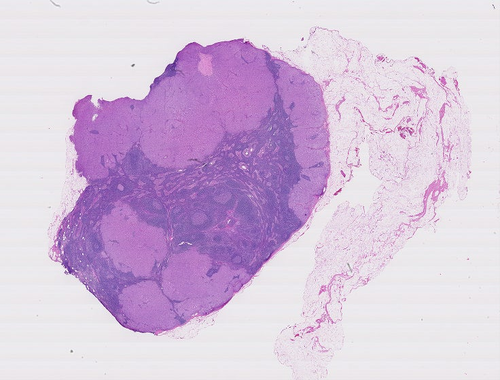

In [21]:
positive_slide = mgr.get_slide('tumor_110')
print('Slide name: "{}"'.format(positive_slide.name))
positive_slide.get_thumbnail((500, 500))

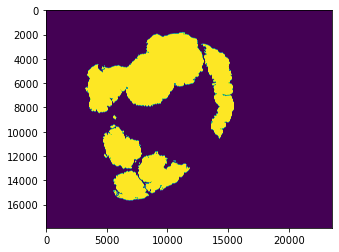

In [22]:
mask = create_tumor_mask(positive_slide, level=2)
plt.imshow(mask)



The function create_tumor_mask takes the polygons from all annotations and creates a binary mask where $0$ represents healthy and $1$ tumorous tissue.

Note: Micro and macro metastases in the CAMELYON data set are annotated exhaustively. However, there might be isolated tumor cells (ITCs) that are not annotated at all. For this reason we only want to use the annotated areas from positive slides as positive tiles and we don't want to use the remaining tissue as negative tiles.

As with the otsu mask for negative slides, creating a tumor mask of a whole slide on a low layer might lead to memory issues. To prevent that we will only generate partial tumor mask for each tile we process.

The split_positive_slide function provides this. As an example we can again split a slide into $128\times128$ tiles on layer 5 and use the TileMap to display the result:


Created 71 tiles.


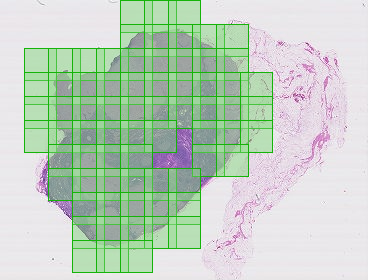

In [23]:
level = 6
tile_size = 128

tile_iter = split_positive_slide(
    positive_slide, level=level,
    tile_size=tile_size,  
    overlap=32)      # no overlap

tm = TileMap(positive_slide)
for _, bounds in tile_iter:
    # add the boundaries of every tile to the map
    tm.add_tile(bounds)

print('Created {} tiles.'.format(len(tm.tiles)))
tm.image


#### Storing

Finally we need to store the preprocessed data in a way we can easily read out and feed into the CNN.

The HDF5-format (Hierarchical Data Format version 5) is a data format designed to store and organize large amounts of data on the hard drive. For python the package h5py offers a rich API around HDF5 that allows us to store and load sets of data very similar to the way we handle NumPy ndarrays.

As an example, let us store one example slide into HDF5:

First, we need to create a new tile iterator. This time we want all the tiles with at least 5% of tissue and a small overlap of 5 pixels. To be able to see which tiles are written we will make a new TileMap as well.


In [24]:
# create a new and unconsumed tile iterator
tile_size = 128
tile_iter = split_negative_slide(negative_slide, level=3,
                                 otsu_threshold=threshold,
                                 tile_size=tile_size, overlap=5,
                                 poi_threshold=0.05)

# initialize map
tm = TileMap(negative_slide)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

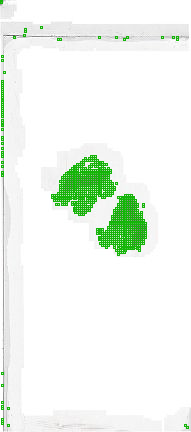

In [25]:
filename = '{}/just_a_testfile_can_be_deleted.hdf5'.format(CAM16_DIR, negative_slide.name, level)
label = 0                                              

with h5py.File(filename, "w", libver='latest') as h5:  
    # creating a date set in the file
    dset = h5.create_dataset('data',                                   
        (0, tile_size, tile_size, 3),                             
        dtype=np.uint8,                                
        maxshape=(None, tile_size, tile_size, 3),                  
        compression="lzf")                             
    
    lset = h5.create_dataset('label', (0,),            
                             maxshape=(None,),
                             dtype=np.uint8)
    cur = 0
    for tile, bounds in tile_iter:                     
        dset.resize(cur + 1, axis=0)                    
        dset[cur:cur + 1] = tile                        

        lset.resize(cur + 1, axis=0)                   
        lset[cur:cur + 1] = label

        cur += 1
        tm.add_tile(bounds)                            
        print('.', end='')

print('\n{} tiles written'.format(cur))
tm.image

Issue a shell command to see how many bytes have been written.

In [26]:
!ls -l {filename} | cut -d' ' -f5,9

50176760 /home/sarah/ForthBrainCancer-Dataset/CAMELYON16//just_a_testfile_can_be_deleted.hdf5


Now we can see what has been written to the file:

In [27]:
with h5py.File(filename, 'r') as h5:
    for key in h5.keys():
        print('Datasets "{}", shape: {}'.format(key, h5[key].shape))

Datasets "data", shape: (1074, 128, 128, 3)
Datasets "label", shape: (1074,)


The numbers match, we can read out five random tiles and their labels:

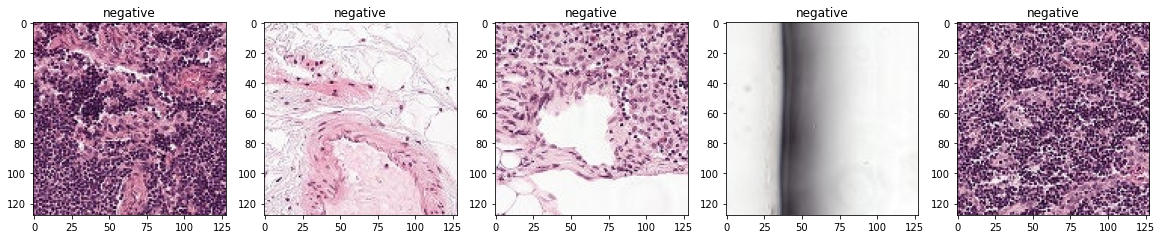

In [28]:
classes = ('negative', 'positive')

plt.figure(figsize=(20, 6))
with h5py.File(filename, 'r') as h5:
    rand_indexes = random.sample(range(len(h5['data'])), k=5)
    for i, idx in enumerate(rand_indexes):
        plt.subplot(1, 5, i+1)
        plt.imshow(h5['data'][idx])
        plt.title(classes[h5['label'][idx]])



We could successfully save and load the tiles.
### Summary and Outlook

We explored the CAMELYON data set and were able to use utilize different tools to extract interesting data from Whole-Slide-Images.

The next step is to process all CAMELYON16 slides and save them into HDF5 format as a single file.
### Licenses
#### Notebook License (CC-BY-SA 4.0)

The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).

data-handling-usage-guide by Klaus Strohmenger
is licensed under a Creative Commons Attribution-ShareAlike 4.0 International License.
Based on a work at https://gitlab.com/deep.TEACHING.
#### Code License (MIT)

The following license only applies to code cells of the notebook.

Copyright 2018 Klaus Strohmenger

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
